## Performance cactus plots (Online SST)

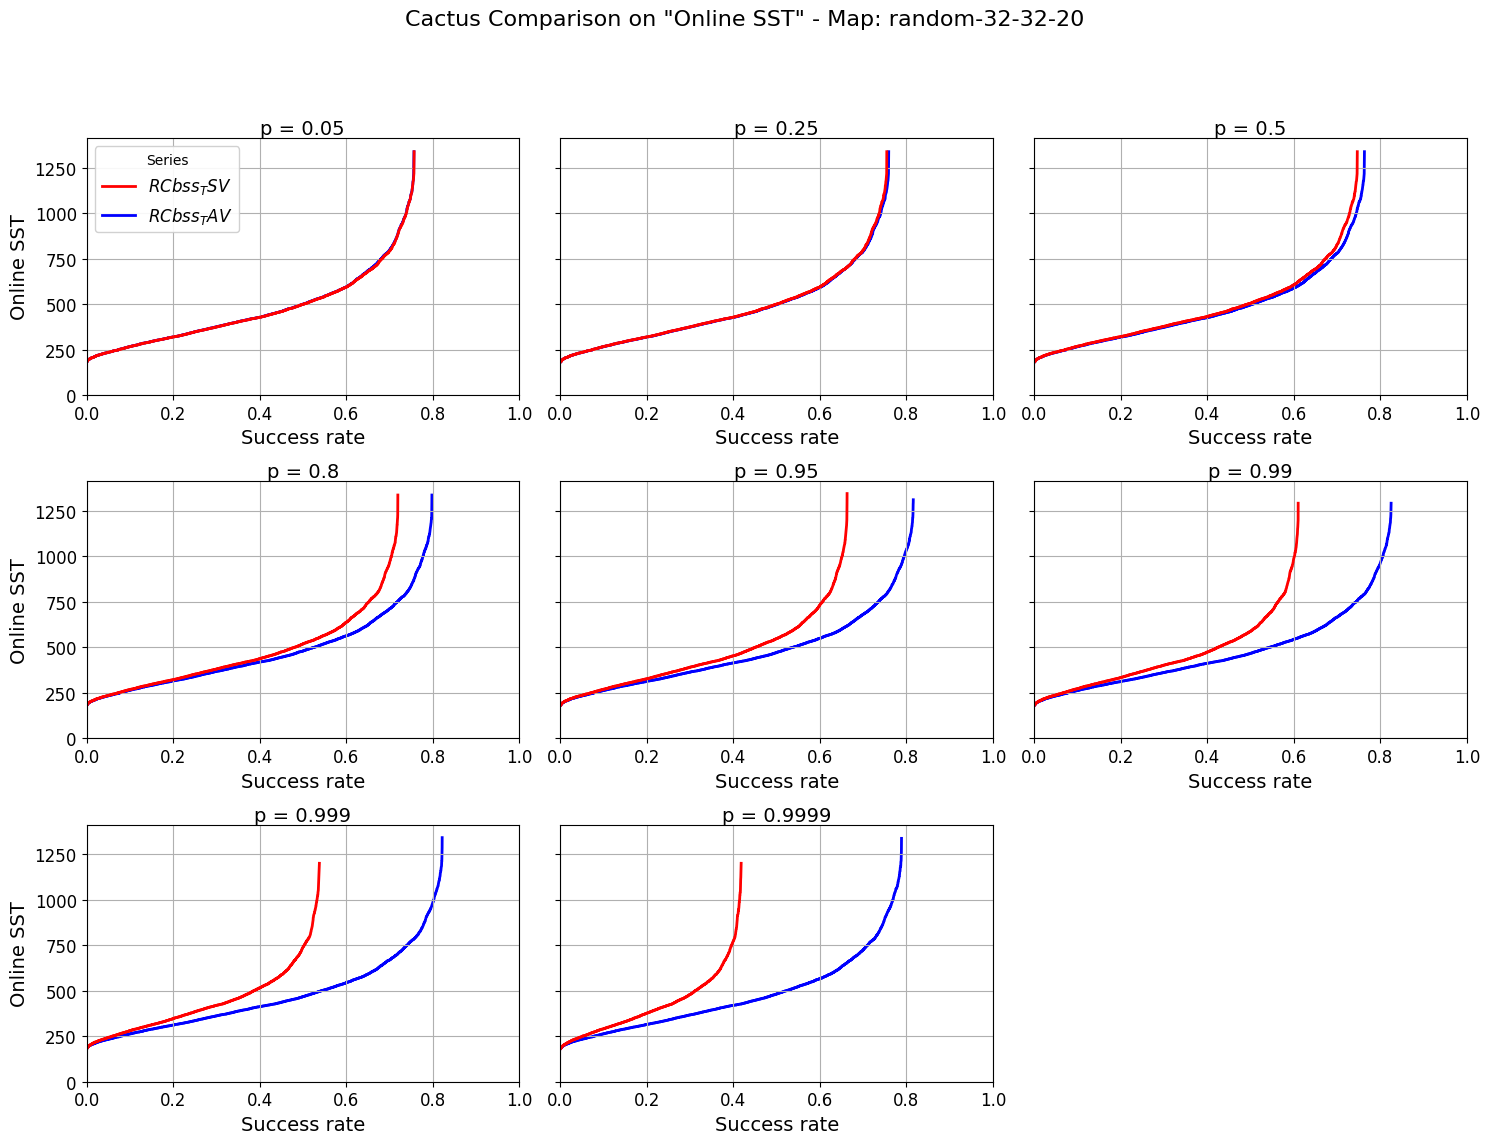

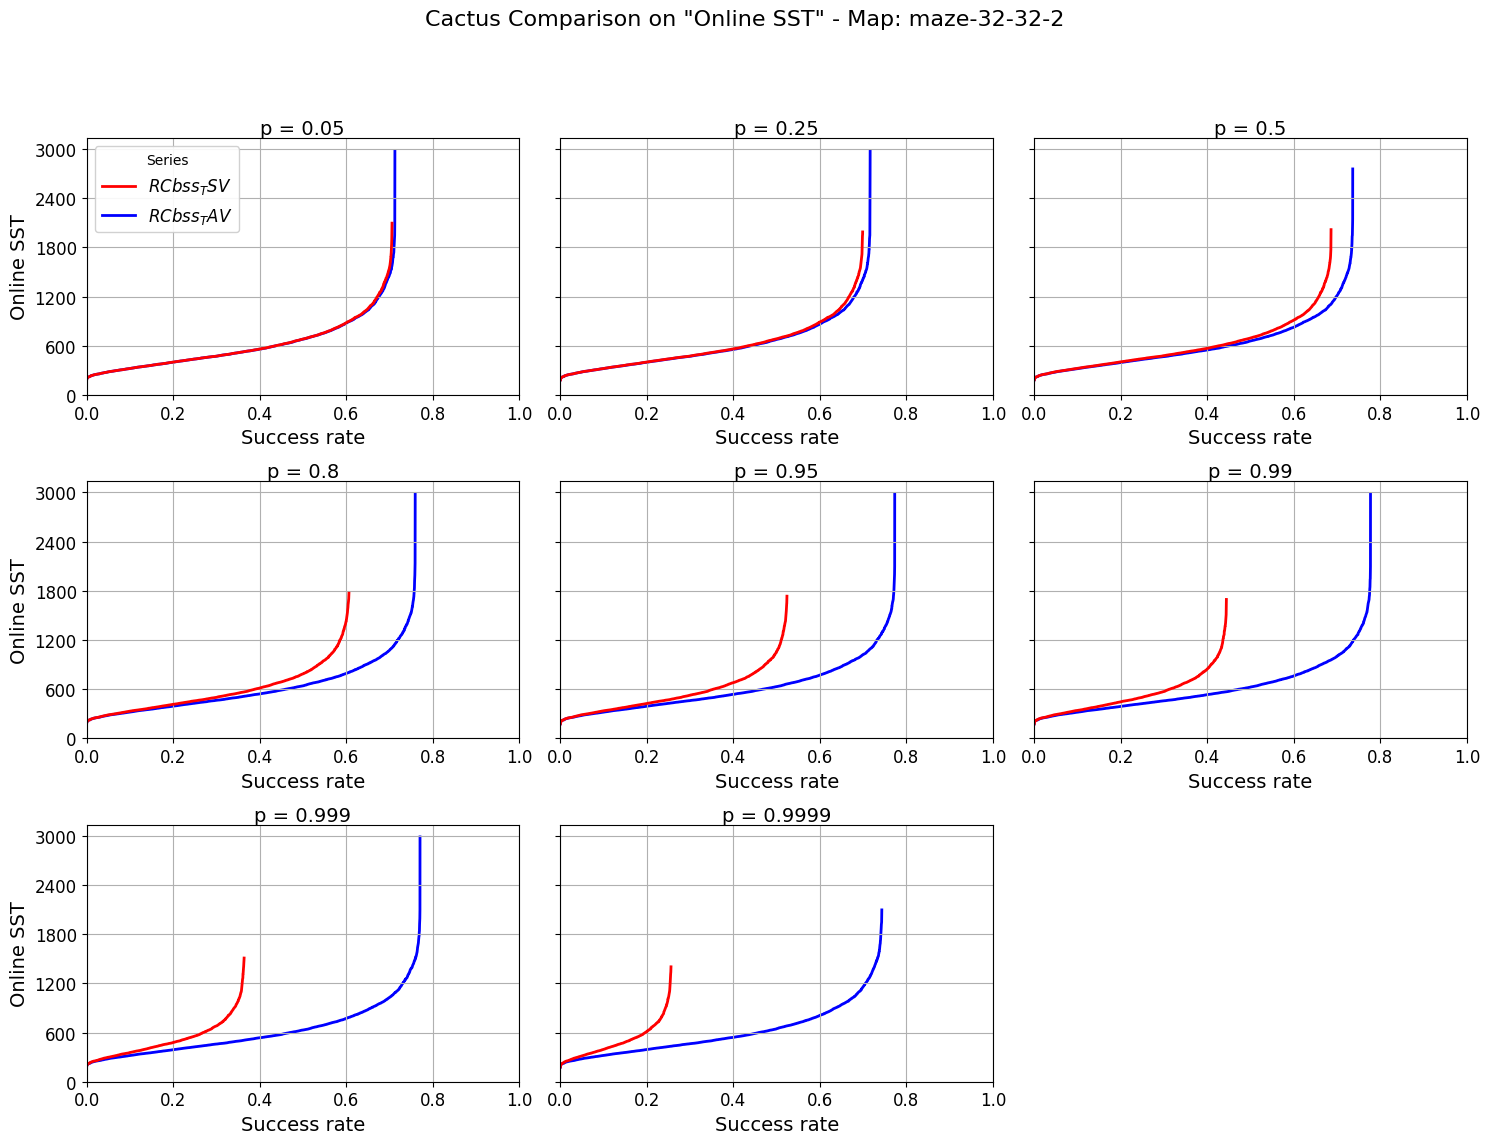

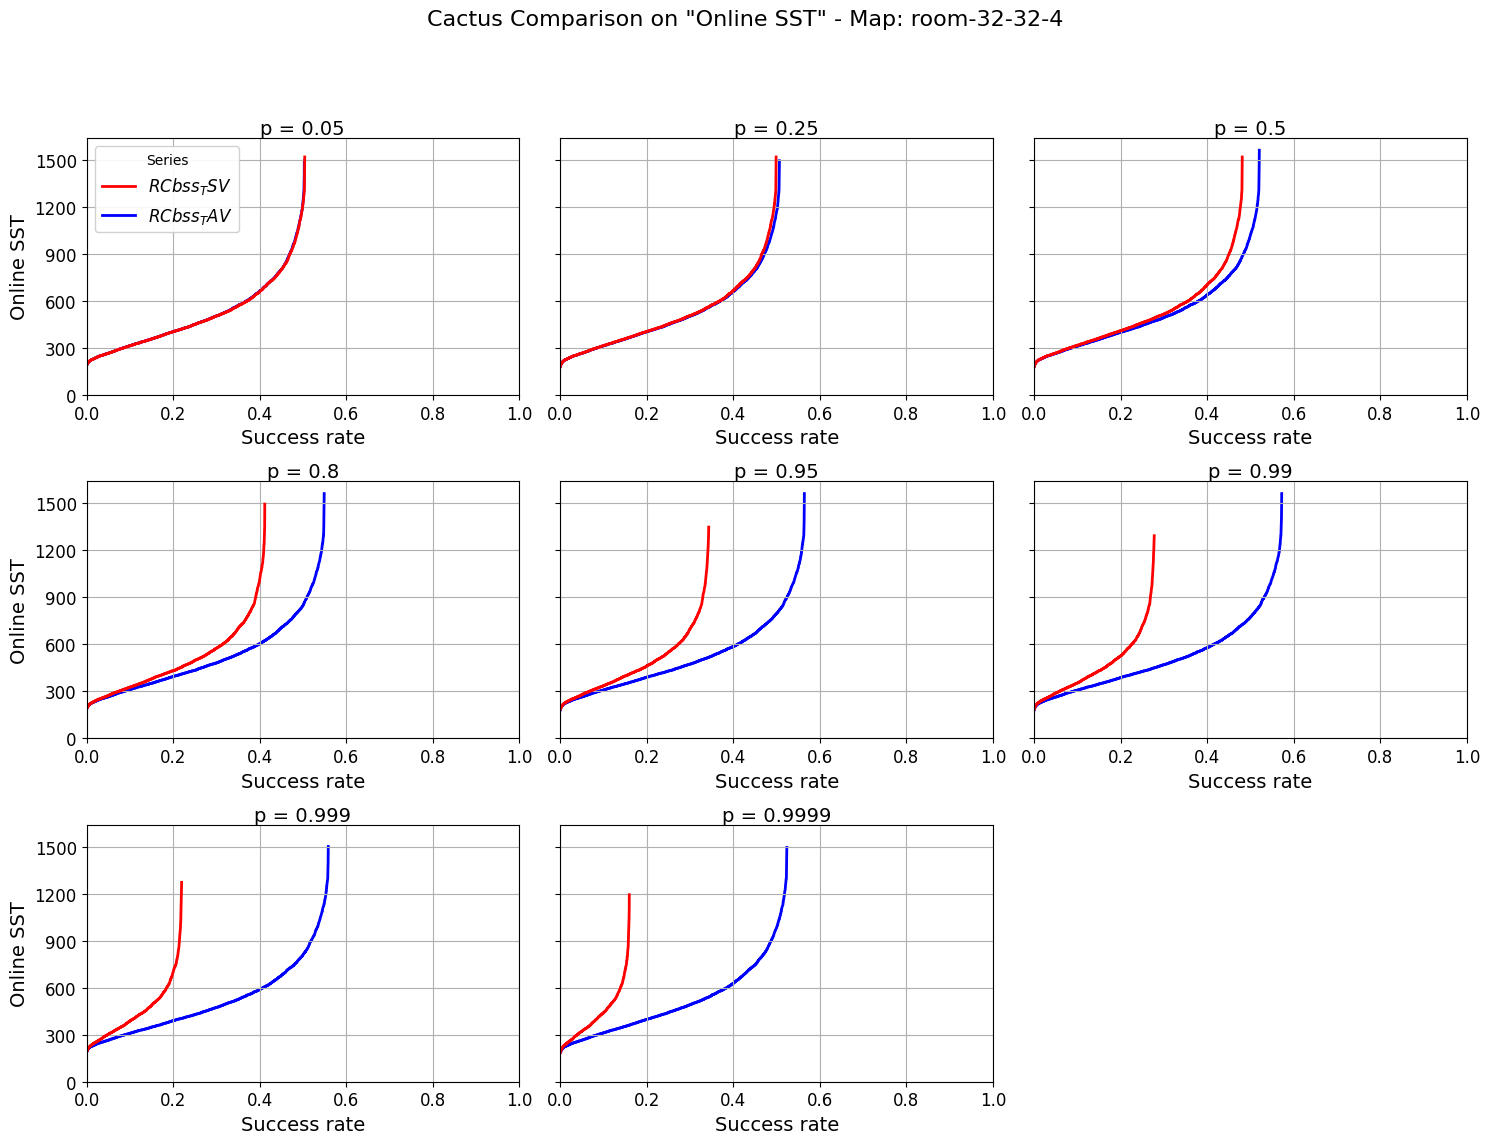

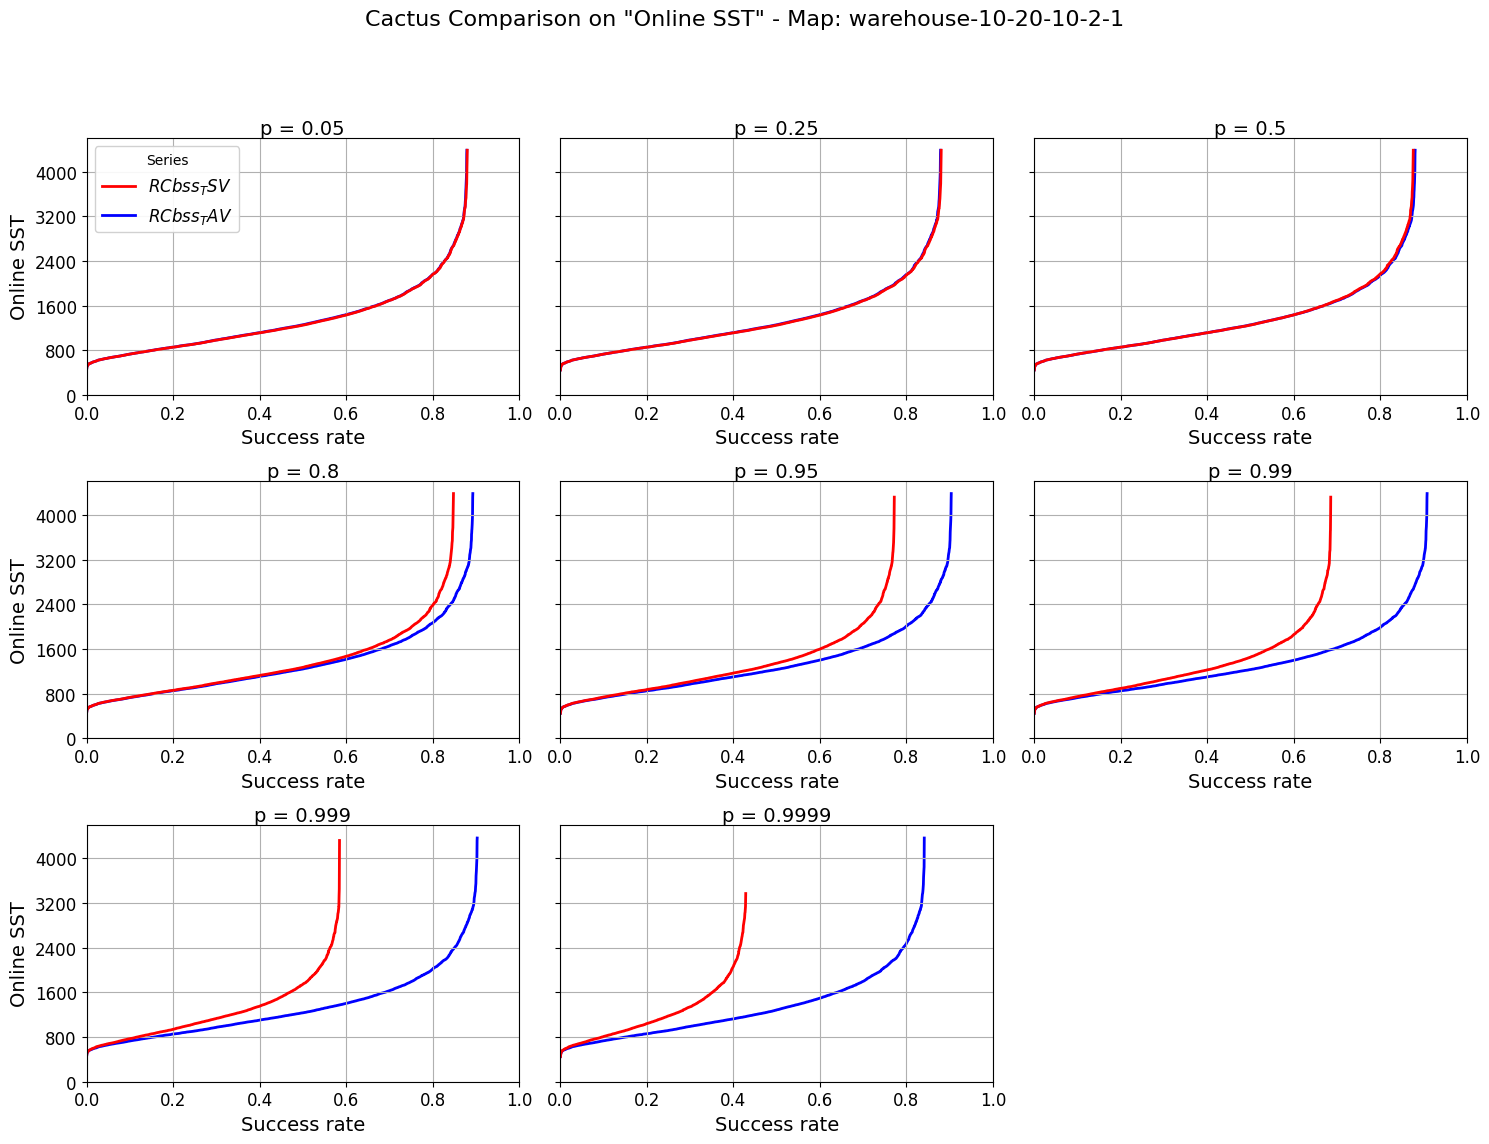

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import math

RCbssTSV_path = "raw_data_RCbssTStrict_BaseLines.csv"
RCbssTAV_path = "raw_data_RCbssTAnytime.csv"

series_info = {
    r"$RCbss_{T}SV$": {"file": RCbssTSV_path, "color": "red"},
    r"$RCbss_{T}AV$": {"file": RCbssTAV_path, "color": "blue"},
}

legend_order = [r"$RCbss_{T}SV$", r"$RCbss_{T}AV$"]
draw_order   = [r"$RCbss_{T}AV$", r"$RCbss_{T}SV$"]
zorder_map   = {r"$RCbss_{T}SV$": 2, r"$RCbss_{T}AV$": 1}

all_maps = ["random-32-32-20", "maze-32-32-2", "room-32-32-4", "warehouse-10-20-10-2-1"]

def get_success_x(total_count, count):
    return [i / total_count for i in range(1, count + 1)]

def load_and_prepare(path):
    df = pd.read_csv(path, dtype={
        'Desired Safe prob': 'string',
        'Min Safe Prob across Plans': 'string'
    }).copy()
    if "Desired Safe prob" in df.columns:
        df["psafe_num"] = pd.to_numeric(df["Desired Safe prob"], errors="coerce")
    else:
        df["psafe_num"] = np.nan
    return df

dfs = {name: load_and_prepare(info["file"]) for name, info in series_info.items()}

psafe_values = sorted({
    v for df in dfs.values()
    for v in df["psafe_num"].dropna().unique()
})[1:]

def plot_cactus_for_metric(metric_col):
    is_prob_metric = (metric_col.lower().strip() == "min safe prob across plans")
    legend_loc = "lower right" if is_prob_metric else "upper left"

    for map_name in all_maps:
        n = len(psafe_values)
        if n == 0:
            continue

        if is_prob_metric:
            y_max_map = 1.0
        else:
            y_max_map = 0.0
            for psafe in psafe_values:
                for label in draw_order:
                    df = dfs[label]
                    if {"Map","psafe_num",metric_col}.issubset(df.columns):
                        vals = df[(df["Map"] == map_name) & (df["psafe_num"] == psafe)][metric_col]
                        vals = pd.to_numeric(vals, errors="coerce").dropna()
                        if not vals.empty:
                            y_max_map = max(y_max_map, vals.max())
            y_max_map = max(1.0, y_max_map * 1.05)

        cols = 3
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(5.0*cols, 4.0*rows), sharey=True)
        fig.suptitle(f'Cactus Comparison on "{metric_col}" - Map: {map_name}', fontsize=16)
        axes = np.atleast_1d(axes).ravel()

        handles_map_global = {}
        first_ax = axes[0]

        for idx, psafe in enumerate(psafe_values):
            ax = axes[idx]

            for label in draw_order:
                df = dfs[label]
                if {"Map","psafe_num",metric_col}.issubset(df.columns):
                    df_subset = df[(df["Map"] == map_name) & (df["psafe_num"] == psafe)]
                    total_trials = len(df_subset)
                    if total_trials == 0:
                        continue
                    df_valid = df_subset[df_subset[metric_col].notna()]
                    if df_valid.empty:
                        continue

                    values = pd.to_numeric(df_valid[metric_col], errors="coerce").dropna().sort_values().reset_index(drop=True)
                    x = get_success_x(total_trials, len(values))

                    line, = ax.plot(
                        x, values,
                        label=label,
                        linewidth=2,
                        color=series_info[label]["color"],
                        zorder=zorder_map[label]
                    )
                    handles_map_global.setdefault(label, line)

            ax.set_title(f"p = {psafe}", pad=2, fontsize=14)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, y_max_map)
            ax.set_xticks(np.linspace(0, 1, 6))
            ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
            ax.grid(True)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.set_xlabel('Success rate', fontsize=14)
            if idx % cols == 0:
                ax.set_ylabel(metric_col, fontsize=14)

        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        ordered = [lbl for lbl in legend_order if lbl in handles_map_global]
        if ordered:
            first_ax.legend(
                [handles_map_global[lbl] for lbl in ordered],
                ordered,
                fontsize=12,
                title="Series",
                loc=legend_loc,
                framealpha=0.9,
                fancybox=True
            )

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()


plot_cactus_for_metric("Online SST")


## Summary table code

In [10]:
import pandas as pd

def print_summary_tables(file_path1, file_path2,
                         all_maps=None,
                         return_tables=False):

    if all_maps is None:
        all_maps = ["random-32-32-20", "maze-32-32-2", "room-32-32-4", "warehouse-10-20-10-2-1"]

    df1 = pd.read_csv(file_path1, dtype={
        'Desired Safe prob': 'string',
        'Min Safe Prob across Plans': 'string'
    })
    df2 = pd.read_csv(file_path2, dtype={
        'Desired Safe prob': 'string',
        'Min Safe Prob across Plans': 'string'
    })

    currAlg = file_path2.split('_')[0]

    def label_from_psafe(psafe):
        if psafe == "NotAvailable":
            return "Cbss_SST"
        elif psafe == "0":
            return "RCbssTStrict with p=0"
        else:
            return f"{currAlg} with p={psafe}"

    def sort_key(level):
        if level.startswith("Cbss_SST"):
            return (0, "")
        if level.startswith("RCbssTSV with p=0"):
            return (1, level)
        try:
            val = float(level.split("p=")[-1])
            return (2, val)
        except Exception:
            return (3, level)

    for map_name in all_maps:
        psafe_vals_1 = df1.loc[df1["Map"] == map_name, "Desired Safe prob"].unique().tolist()
        unique_psafe_values = sorted(set(psafe_vals_1), key=lambda x: (str(x)))

        rows = []
        for psafe in unique_psafe_values:
            label = label_from_psafe(psafe)

            sub1 = df1[(df1["Map"] == map_name) & (df1["Desired Safe prob"] == psafe)]
            total_cases = len(sub1)

            failures_count = int(sub1["Runtime"].isna().sum())
            failures_pct = (100.0 * failures_count / total_cases) if total_cases > 0 else 0.0
            failures_str = f"{failures_pct:.2f}%"

            sub2 = df2[(df2["Map"] == map_name) & (df2["Desired Safe prob"] == psafe)]
            success_all_total = len(sub2) if len(sub2) > 0 else 1  # הימנעות מחלוקה ב-0
            replan_ge1_count = int(pd.to_numeric(sub2["Number Of Replans"], errors="coerce").ge(1).sum()) if len(sub2) > 0 else 0
            replan_ge1_pct = (100.0 * replan_ge1_count / success_all_total)
            replan_ge1_str = f"{replan_ge1_pct:.2f}%"

            avg_online = float(pd.to_numeric(sub2["Online Runtime"], errors="coerce").mean()) if len(sub2) > 0 else float('nan')
            avg_online_tst = float(pd.to_numeric(sub2["Online SST"], errors="coerce").mean()) if len(sub2) > 0 else float('nan')

            avg_expanded_nodes = float(pd.to_numeric(sub1["Number of Expands"], errors="coerce").mean()) if len(sub1) > 0 else float('nan')

            rows.append({
                "Planner Configurations": label,
                "Failures": failures_str,
                "≥1 replan": replan_ge1_str,
                "Avg Online Runtime (sec)": round(avg_online, 2) if pd.notna(avg_online) else float('nan'),
                "Avg Online SST": round(avg_online_tst, 2) if pd.notna(avg_online_tst) else float('nan'),
                "Avg expanded nodes": round(avg_expanded_nodes, 2) if pd.notna(avg_expanded_nodes) else float('nan'),
            })

        table = pd.DataFrame(rows, columns=[
            "Planner Configurations",
            "Failures",
            "≥1 replan",
            "Avg Online Runtime (sec)",
            "Avg Online SST",
            "Avg expanded nodes"
        ])

        table = table.sort_values(
            by="Planner Configurations",
            key=lambda s: s.map(sort_key)
        ).reset_index(drop=True)

        print(f"\n==== Summary table for map: {map_name} ====\n")

        cols = table.columns.tolist()
        col_widths = {c: table[c].astype(str).map(len).max() for c in cols}
        for c in cols:
            col_widths[c] = max(col_widths[c], len(str(c)))

        def format_val(val, width, align="center"):
            s = str(val)
            if align == "left":
                return s.ljust(width)
            elif align == "center":
                pad = width - len(s)
                left = pad // 2
                right = pad - left
                return " " * left + s + " " * right
            else:
                return s.rjust(width)

        header = " | ".join([
            format_val(c, col_widths[c], align=("left" if i == 0 else "center"))
            for i, c in enumerate(cols)
        ])
        print(header)
        print("-" * len(header))

        for _, row in table.iterrows():
            line = " | ".join([
                format_val(row[c], col_widths[c], align=("left" if i == 0 else "center"))
                for i, c in enumerate(cols)
            ])
            print(line)


## Summary table for RCbssTSV vs Baselines

In [11]:
print_summary_tables("raw_data_RCbssTStrict_BaseLines.csv", "RCbssTStrict_BaseLines_All_Success_Per_Instance.csv")


==== Summary table for map: random-32-32-20 ====

Planner Configurations     | Failures | ≥1 replan | Avg Online Runtime (sec) | Avg Online SST | Avg expanded nodes
------------------------------------------------------------------------------------------------------------------
Cbss_SST                   |  25.65%  |   5.25%   |           1.18           |     419.91     |        2.52       
RCbssTStrict with p=0      |  24.07%  |   7.95%   |           1.78           |     419.87     |        1.42       
RCbssTStrict with p=0.05   |  24.26%  |   7.25%   |           1.7            |     419.55     |        2.79       
RCbssTStrict with p=0.25   |  24.54%  |   6.55%   |           1.52           |     419.61     |        7.87       
RCbssTStrict with p=0.5    |  25.32%  |   4.87%   |           1.12           |     419.63     |       38.84       
RCbssTStrict with p=0.8    |  28.03%  |   2.73%   |           0.59           |     419.63     |       174.51      
RCbssTStrict with p=0.95   | 

## Summary table for RCbssTAV

In [12]:
print_summary_tables("raw_data_RCbssTAnytime.csv", "RCbssTAnytime_All_Success_Per_Instance.csv")


==== Summary table for map: random-32-32-20 ====

Planner Configurations      | Failures | ≥1 replan | Avg Online Runtime (sec) | Avg Online SST | Avg expanded nodes
-------------------------------------------------------------------------------------------------------------------
RCbssTAnytime with p=0.05   |  24.31%  |  22.22%   |           5.75           |     461.28     |        3.67       
RCbssTAnytime with p=0.25   |  24.10%  |  21.32%   |           5.54           |     461.3      |        8.24       
RCbssTAnytime with p=0.5    |  23.67%  |  18.76%   |           5.03           |     461.38     |       29.13       
RCbssTAnytime with p=0.8    |  20.15%  |  13.39%   |           3.8            |     461.55     |       117.54      
RCbssTAnytime with p=0.95   |  18.42%  |   9.12%   |           3.01           |     461.64     |       174.76      
RCbssTAnytime with p=0.99   |  17.50%  |   8.02%   |           2.83           |     461.53     |       84.72       
RCbssTAnytime with p=